In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [ ]:
path = kagglehub.dataset_download("patrickfleith/nasa-battery-dataset")

Using Colab cache for faster access to the 'nasa-battery-dataset' dataset.


In [ ]:
V_CUTOFF = 2.7
CAPACITY_MIN_AH = 1.0
BINS = 20
M = 200 # physics resolution
NOMINAL_AH = 2.0

In [ ]:
metadata = pd.read_csv(os.path.join(path, "cleaned_dataset", "metadata.csv"))
metadata["battery_id"] = metadata["battery_id"].astype(str)

excluded_batteries = ["B0049", "B0050", "B0051", "B0052"]
discharge_metadata = metadata[
    (metadata["type"] == "discharge") &
    (~metadata["battery_id"].isin(excluded_batteries))
].copy()

discharge_metadata["cycle_number"] = discharge_metadata.groupby("battery_id").cumcount() + 1

main_rows = []
phys_rows = []

In [ ]:
for _, row in tqdm(discharge_metadata.iterrows(), total=len(discharge_metadata)):
    file_path = os.path.join(path, "cleaned_dataset", "data", row["filename"])

    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        continue
    # sorting
    df = df.sort_values("Time").drop_duplicates(subset=["Time"], keep="first")

    if len(df) < 5: continue

    # truncate at cutoff voltage
    cutoff_idx = df[df["Voltage_measured"] < V_CUTOFF].index.min()
    if not pd.isna(cutoff_idx):
        df = df.loc[:cutoff_idx].copy()

    if len(df) < 5: continue

    # Coulomb Counting (Integration)
    df["dt_hr_raw"] = df["Time"].diff().fillna(0) / 3600.0
    df["dQ"] = df["Current_measured"] * df["dt_hr_raw"]
    capacity = abs(df["dQ"].sum())

    # Skip invalid capacities
    if capacity <= CAPACITY_MIN_AH or capacity >= NOMINAL_AH:
        continue

    # Calculate SOC and SOH
    df["CumQ"] = df["dQ"].cumsum()
    # SoC = (Remaining Capacity / Total Capacity of this cycle) * 100
    # dQ is negative during discharge, so CumQ decreases.
    # We assume start is 100%.
    df["SoC"] = 100.0 * (1.0 + df["CumQ"] / capacity)

    soh_value = 100.0 * capacity / NOMINAL_AH

    # resampling
    t = df["Time"].to_numpy()
    t0, t1 = float(t[0]), float(t[-1])
    if t1 <= t0: continue

    t_grid = np.linspace(t0, t1, M)
    dt_hr = np.diff(t_grid, prepend=t_grid[0]) / 3600.0

    def interp(col):
        return np.interp(t_grid, t, df[col].to_numpy())

    Vg   = interp("Voltage_measured")
    Ig   = interp("Current_measured")
    Tg   = interp("Temperature_measured")
    SOCg = interp("SoC")

    # PHYSICS DATASET (resampled, not binned)
    for j in range(M):
        phys_rows.append({
            "battery_id": row["battery_id"],
            "cycle_number": row["cycle_number"],
            "t_idx": j,
            "Time_s": t_grid[j] - t0,
            "dt_hr": dt_hr[j],
            "Voltage_measured": Vg[j],
            "Current_measured": Ig[j],
            "Temperature_measured": Tg[j],
            "SoC": SOCg[j],
            "Capacity_Ah": capacity,
            "SoH": soh_value,
            "t_end_s": (t1 - t0),
        })

    # MAIN DATASET (20 bins from the resampled series)
    rs = pd.DataFrame({
        "Time_s": t_grid - t0,
        "dt_hr": dt_hr,
        "Voltage_measured": Vg,
        "Current_measured": Ig,
        "Temperature_measured": Tg,
        "SoC": SOCg,
    })

    chunks = np.array_split(rs, BINS)
    if len(chunks) != BINS or any(c.empty for c in chunks):
        continue

    for b_idx, c in enumerate(chunks):
        main_rows.append({
            "battery_id": row["battery_id"],
            "cycle_number": row["cycle_number"],
            "bin_idx": b_idx,
            "Time_s": c["Time_s"].mean(),
            "dt_hr": c["dt_hr"].sum(), # Sum time for correct integration later
            "Voltage_measured": c["Voltage_measured"].mean(),
            "Current_measured": c["Current_measured"].mean(),
            "Temperature_measured": c["Temperature_measured"].mean(),
            "SoC": c["SoC"].mean(),
            "Capacity_Ah": capacity,
            "SoH": soh_value,
            "t_end_s": (t1 - t0),
        })

  0%|          | 0/2694 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 3/2694 [00:00<01:33, 28.71it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  retu

In [ ]:
main_df = pd.DataFrame(main_rows)
phys_df = pd.DataFrame(phys_rows)

main_df.to_csv("battery_main_binned20.csv", index=False)
phys_df.to_csv("battery_phys_resampled200.csv", index=False)

print("Saved:", main_df.shape, phys_df.shape)

Saved: (45660, 12) (456600, 12)


In [ ]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
main_df = pd.read_csv("battery_main_binned20.csv")
feature_cols = ["Voltage_measured", "Current_measured", "Temperature_measured"]
target_col = "SoH"

In [ ]:
cycle_ids = main_df.groupby(["battery_id", "cycle_number"]).size().reset_index()
complete_cycles = cycle_ids[cycle_ids[0] == 20][["battery_id", "cycle_number"]]
data_clean = main_df.merge(complete_cycles, on=["battery_id", "cycle_number"])
data_clean = data_clean.sort_values(["battery_id", "cycle_number", "bin_idx"])

In [ ]:
num_cycles = len(complete_cycles)
X_raw = data_clean[feature_cols].values.reshape(num_cycles, 20, len(feature_cols))
y_raw = data_clean.groupby(["battery_id", "cycle_number"])[target_col].mean().values

print(f"Data Shape: {X_raw.shape}") # Should be (N, 20, 3)
print(f"Target Shape: {y_raw.shape}") # Should be (N,)

Data Shape: (2283, 20, 3)
Target Shape: (2283,)


In [ ]:
scaler = MinMaxScaler()

X_flat = X_raw.reshape(-1, len(feature_cols))
X_scaled_flat = scaler.fit_transform(X_flat)
X_scaled = X_scaled_flat.reshape(num_cycles, 20, len(feature_cols))

y_scaled = y_raw / 100.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=True
)

In [ ]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1) # Shape (N, 1)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

In [ ]:
# Transformer
import torch.nn as nn
import math
import matplotlib.pyplot as plt


In [ ]:
# Transformer components
class PositionalEncoding(nn.Module):
    """
    Injects information about the relative or absolute position of the tokens in the sequence.
    Transformers don't have built-in order like RNNs, so this is crucial for time-series.
    """
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :].unsqueeze(0)

class SOHTransformer(nn.Module):
    def __init__(self, input_dim=3, d_model=64, nhead=4, num_layers=2, output_dim=1):
        super(SOHTransformer, self).__init__()

        # Feature Embedding: Map (V, I, T) -> d_model (High dim space)
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)

        output = self.transformer_encoder(src)
        output = output.mean(dim=1)

        prediction = self.decoder(output)
        return prediction

In [ ]:
# Initialization, Training

INPUT_DIM = 3   # Voltage, Current, Temp
D_MODEL = 64    # Internal dimension size
N_HEAD = 4      # Number of attention heads
NUM_LAYERS = 2  # Number of encoder layers
LEARNING_RATE = 0.001
EPOCHS = 150

model = SOHTransformer(input_dim=INPUT_DIM, d_model=D_MODEL, nhead=N_HEAD, num_layers=NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model Architecture:")
print(model)

print("\nStarting Training...")
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)

print(f"\nFinal Test Loss (MSE): {test_loss.item():.6f}")

Model Architecture:
SOHTransformer(
  (embedding): Linear(in_features=3, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=1, bias=True)
)

Starting Training...
Epoch [10/150] | Loss: 0.146886
Epoch [20/150] | Loss: 0.0176

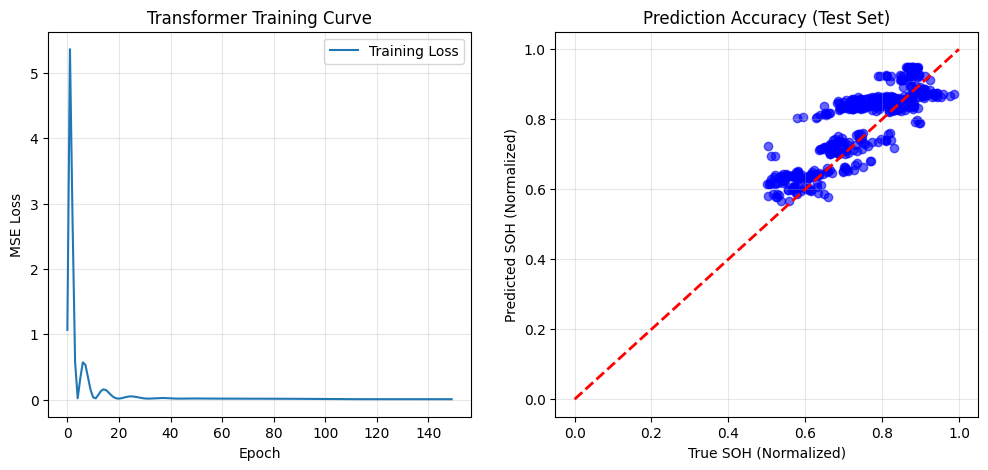

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Transformer Training Curve")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
y_true = y_test_tensor.numpy()
y_pred = test_predictions.numpy()

plt.scatter(y_true, y_pred, alpha=0.6, color='blue')
plt.plot([0, 1], [0, 1], 'r--', lw=2)
plt.xlabel("True SOH (Normalized)")
plt.ylabel("Predicted SOH (Normalized)")
plt.title("Prediction Accuracy (Test Set)")
plt.grid(True, alpha=0.3)

plt.show()